In [24]:
from collections import namedtuple
from itertools import count
import random
import os, time
import numpy as np

import torch
import torch.nn as nn
from stable_baselines3.common.env_checker import check_env
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal, Categorical
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from time import sleep
import datetime
import argparse
import pickle
from collections import namedtuple
from itertools import count
import random
import os, time
import numpy as np
import sys
import logging
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from time import sleep
import datetime
import random
import numpy as np
import pandas as pd
from numba import njit, prange
#IMPORTS
import random
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from stable_baselines3 import PPO, DDPG, TD3
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.env_util import SubprocVecEnv, DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import VecNormalize, VecFrameStack
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback
import seaborn as sns
import gymnasium as gym
from gymnasium import spaces
from gymnasium.wrappers import NormalizeObservation

In [26]:
tt_array = np.load("/Users/xiawu/RL4PT/results/PPO_Mon Sep 11 19:18:38 2023/train_result/4_ppo_flow.npy")
toll_array = np.load("/Users/xiawu/RL4PT/results/PPO_Mon Sep 11 19:18:38 2023/train_result/4_ppo_toll.npy")
token_array = np.load("/Users/xiawu/RL4PT/results/PPO_Mon Sep 11 19:18:38 2023/train_result/4_ppo_tokentrade.npy")
user_array = np.load("/Users/xiawu/RL4PT/results/PPO_Mon Sep 11 19:18:38 2023/train_result/4_ppo_usertrade.npy")

In [29]:
toll_array[-1][-1]

array([473.7411207 ,  69.5561808 ,   4.51865512])

/var/folders/v5/1ps6ddfj74n06jd3__193xch0000gp/T/ipykernel_23903/154462450.py:10: RuntimeWarning: divide by zero encountered in divide
  return A*np.exp(-(x-mu)**2/2/(sigma)**2)
/var/folders/v5/1ps6ddfj74n06jd3__193xch0000gp/T/ipykernel_23903/154462450.py:10: RuntimeWarning: invalid value encountered in divide
  return A*np.exp(-(x-mu)**2/2/(sigma)**2)


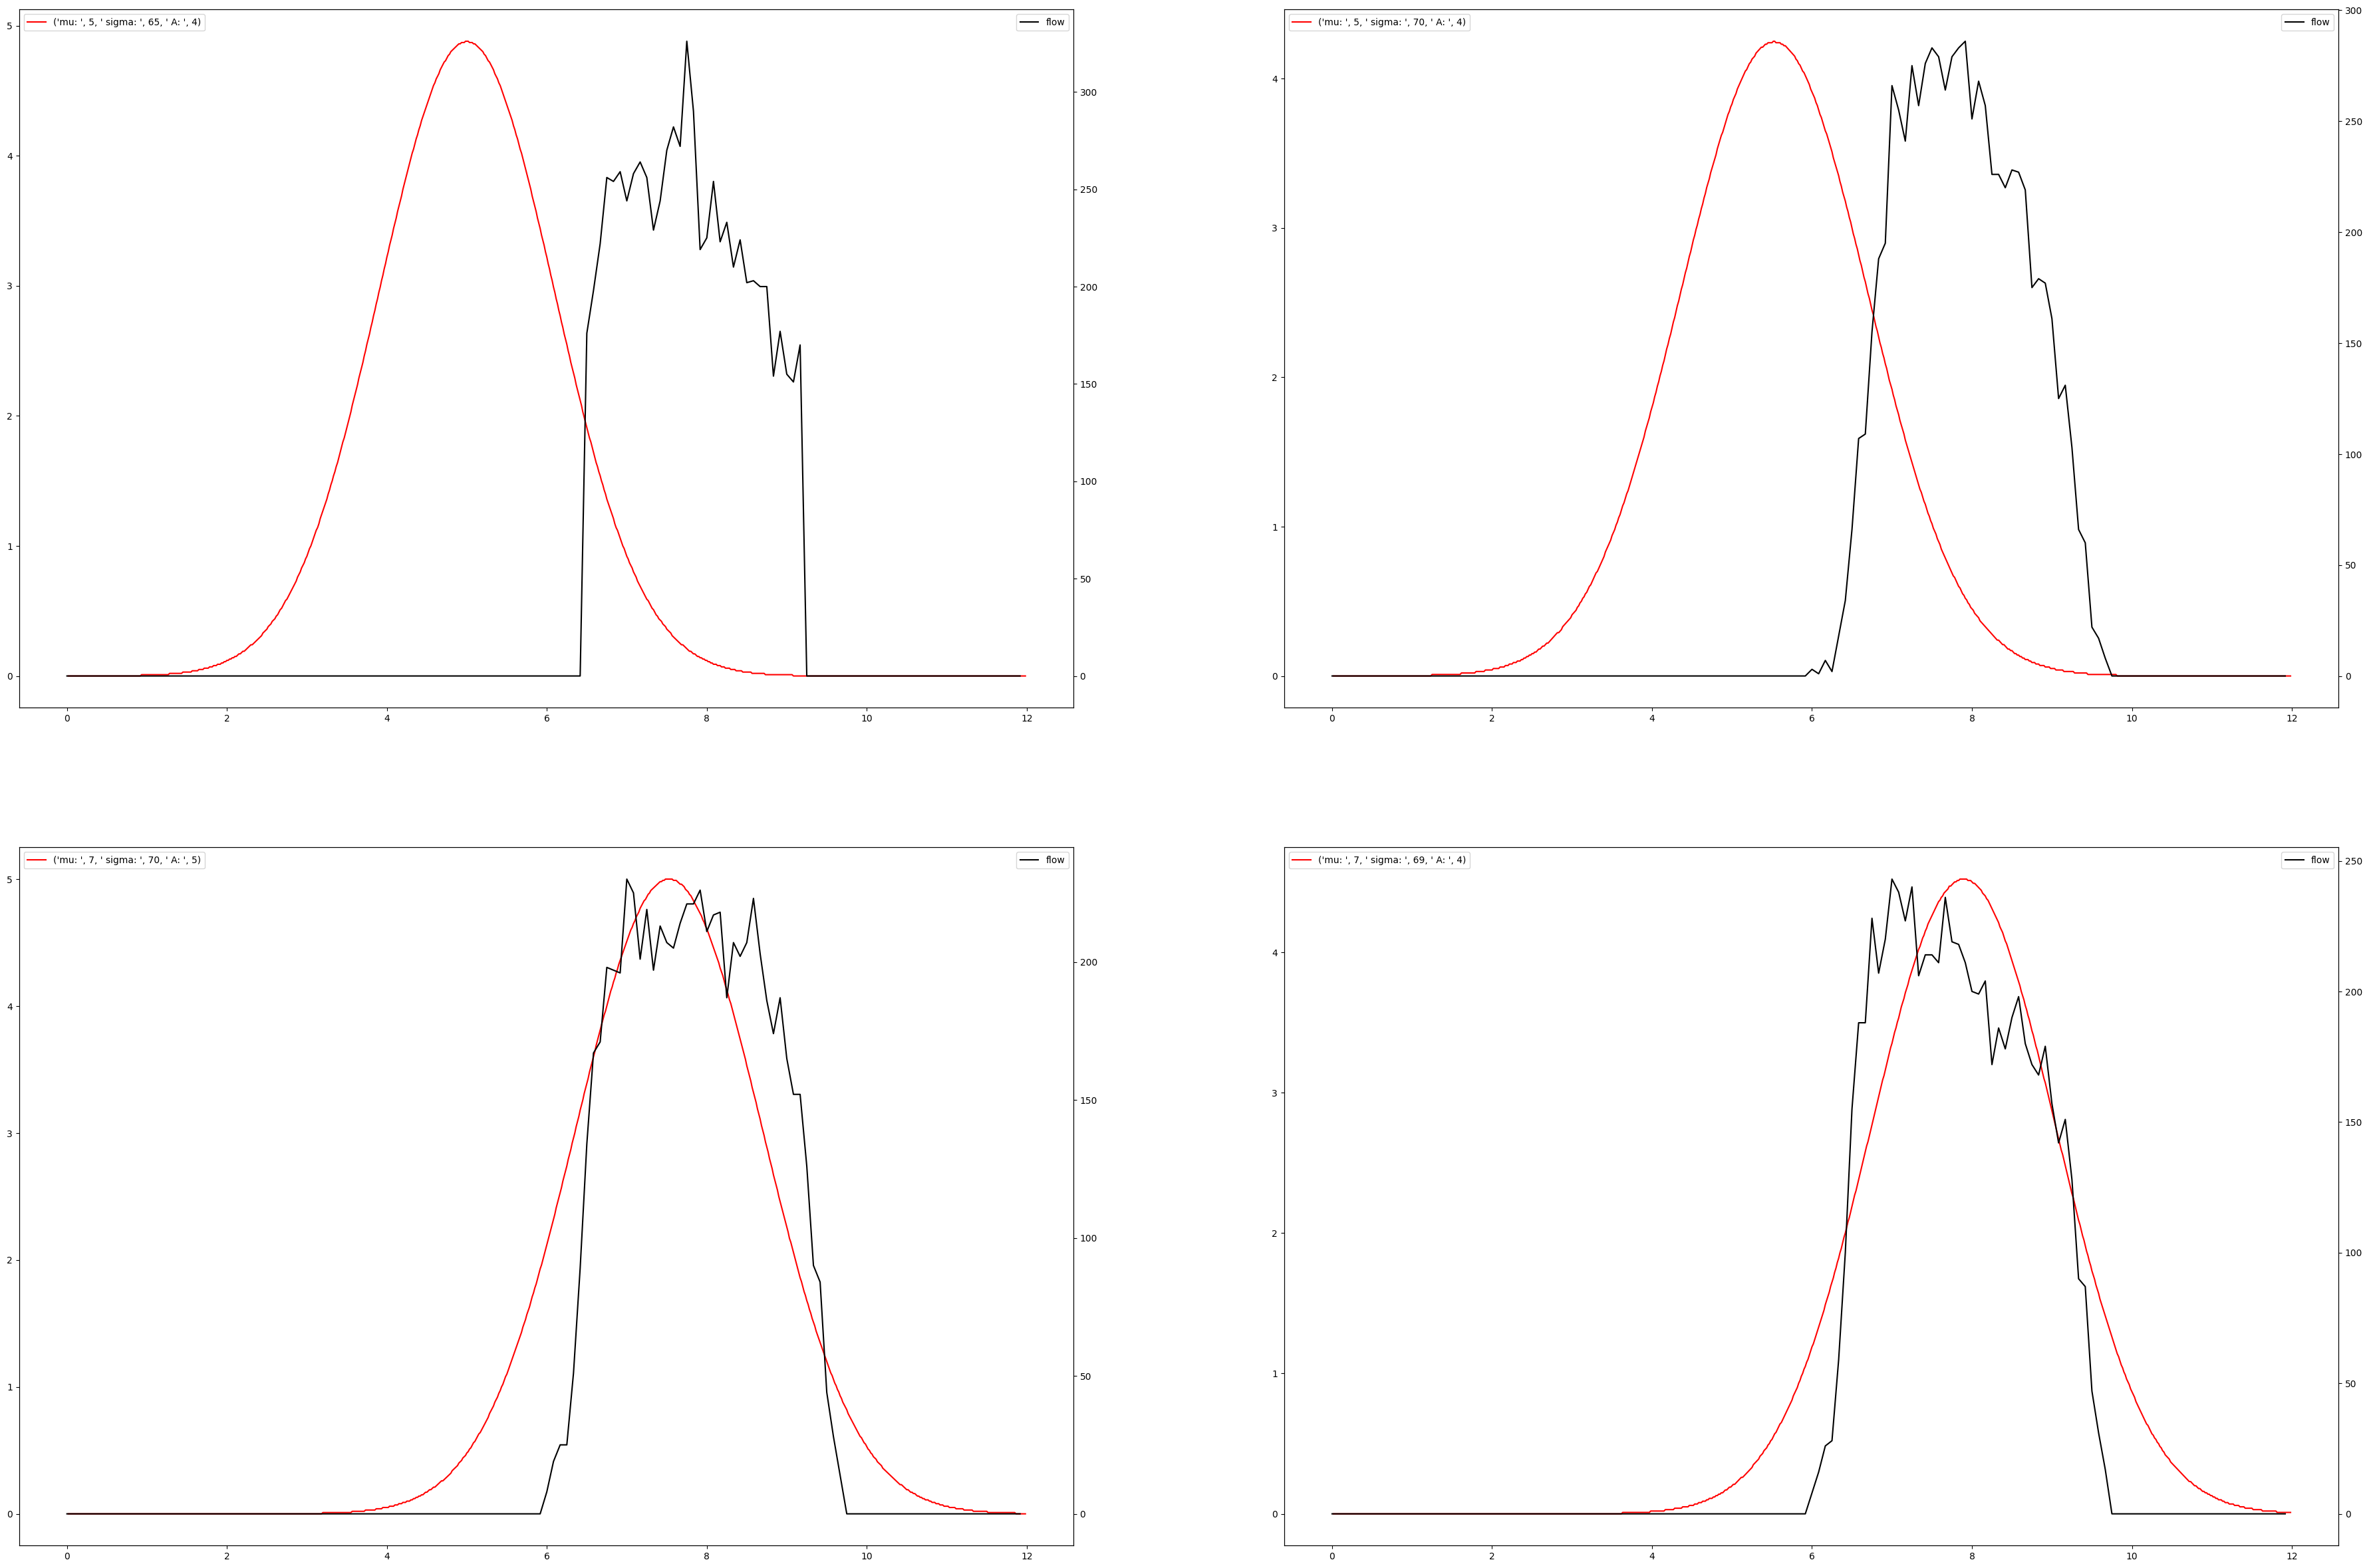

In [30]:
prob = np.histogram(tt_array[-1][-1][:, 0], bins =144, range = (0, 720))[0]

episode_time = -1
simulation_day = 4
nrows = 2

ncols= int(simulation_day/nrows)
def bimodal_2( x, mu1, sigma1, A1, mu2=0, sigma2=0, A2=0):
    def custgauss(x,mu,sigma,A):
        return A*np.exp(-(x-mu)**2/2/(sigma)**2)
    return custgauss(x,mu1,sigma1,A1)+custgauss(x,mu2,sigma2,A2)

fig, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize = (45, 30)) 
for row in range(nrows):
    for col in range(ncols): 
        current_day=(row*nrows+col)
        toll_1 = toll_array[episode_time][current_day]

        timeofday = np.arange(12*60) # the toll fees of the day
        toll_profile_1 = np.round(np.repeat(np.maximum(bimodal_2(timeofday[np.arange(0, 12*60, 1)], *toll_1),0),1), 2)
        label_context_1 = ("mu: ", int(toll_1[0]/60), " sigma: ", int(toll_1[1]), " A: ", int(toll_1[2]))

        axs[row, col].plot(np.arange(0,720)/60, toll_profile_1[np.arange(0,720)], color='red', label = label_context_1)
        axs[row, col].legend(loc= 'upper left')
        
        ax_2 =  axs[row, col].twinx()
        prob = np.histogram(tt_array[episode_time][current_day][:, 0], bins =144, range = (0, 720))[0]
        ax_2.plot(np.arange(0,720, 5)/60, prob, color='black', label = "flow")
        #axs[row, col].legend()
  
        ax_2.legend()

plt.savefig("toll and flow.jpg")

In [6]:
token_array.shape

(4, 4, 720, 2)

In [8]:
tt_df = pd.read_csv("./output/Bottleneck/NT/flowdf.csv")["tt"]
print(np.mean(tt_df))


tt_df = pd.read_csv("./output/Bottleneck/Trinity_normal/flowdf.csv")["tt"]
np.mean(tt_df)

35.264292266666665


34.93299626666668

In [4]:
3000*0.15

450.0

In [4]:
np.load("output/BO/optimal_Travel_tt.npy")

array(32.43552396)

In [6]:
travel_time_array = np.load("output/BO/travel_time_converge.npy")
toll_record_array = np.load("output/BO/toll_record.npy")

optimal_index = np.argmin(travel_time_array)
optimal_toll =toll_record_array[optimal_index, :]
optimal_toll.tolist()

[0.5547902096366654, -0.5903404805363967, -1.0]

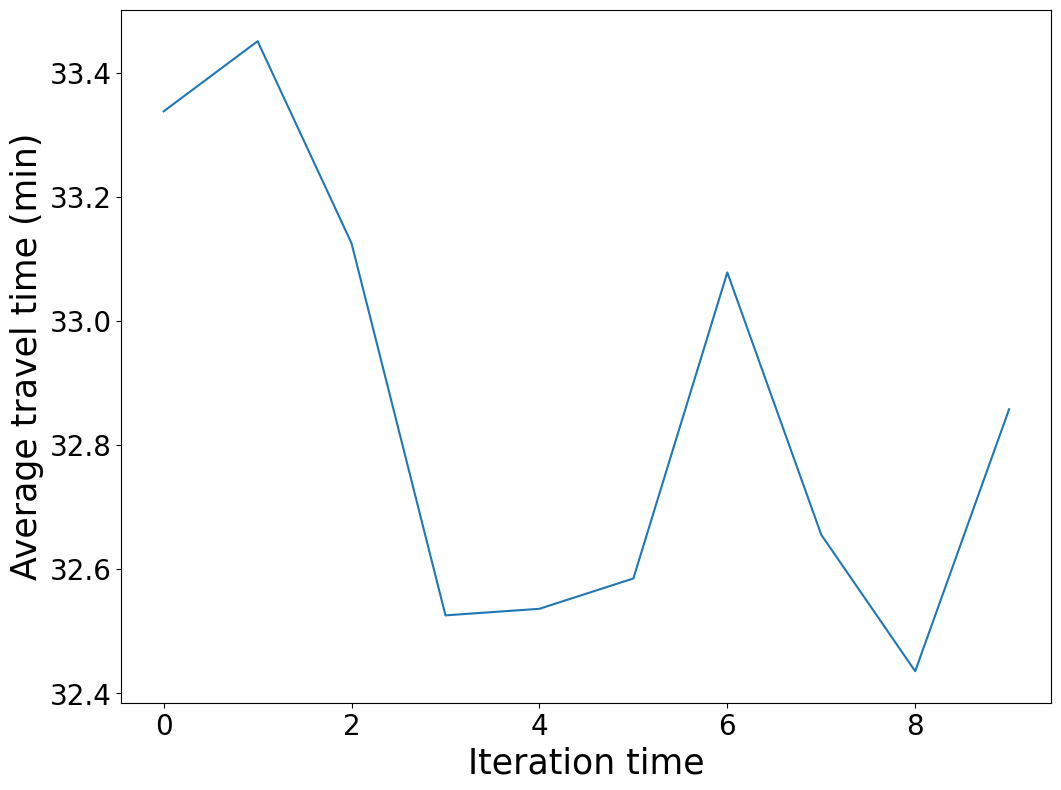

In [20]:
fig, ax = plt.subplots(figsize=(12,9))
plt.plot(travel_time_array,label='Daily average travel time')
plt.xlabel("Iteration time",fontsize=25)
plt.ylabel("Average travel time (min)",fontsize=25)
ax.tick_params(axis='x', labelsize= 20)
ax.tick_params(axis='y', labelsize= 20)
fig.savefig('./plot/BO//travel time converge.png', dpi=fig.dpi)


In [22]:
optimal_toll.tolist()

[0.5547902096366654, -0.5903404805363967, -1.0]

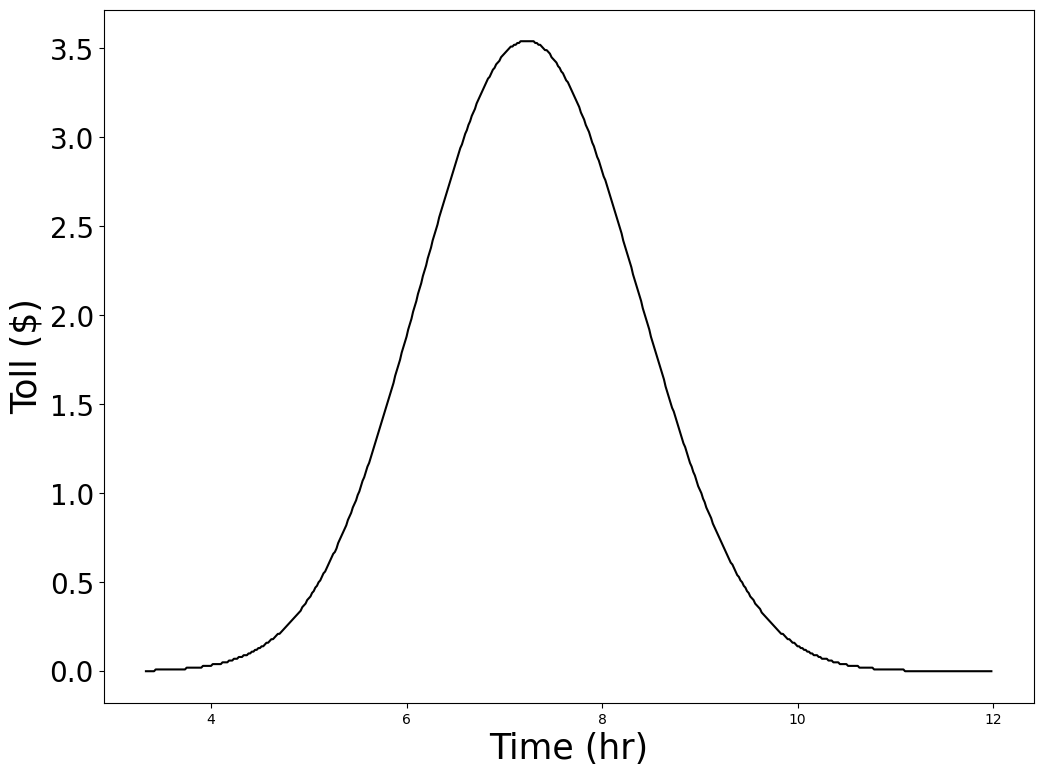

In [24]:

def bimodal_plot(x,mu1,sigma1,A1, mu2=0, sigma2=0, A2=0):
    def custgauss(x,mu,sigma,A):
        mu = mu*120 + 420 # 300, 540
        sigma = sigma*10 + 60 # 50, 70
        A = A*2 + 3 # 1,5
        return A*np.exp(-(x-mu)**2/2/(sigma)**2)
    return custgauss(x,mu1,sigma1,A1)+custgauss(x,mu2,sigma2,A2)

timeofday = np.arange(12*60) # the toll fees of the day
toll_profile = np.repeat(np.maximum(bimodal_plot(timeofday[np.arange(0, 12*60, 1)], *optimal_toll),0),1)
toll_profile = np.around(toll_profile, 2)

fig, ax = plt.subplots(figsize=(12,9))
plt.plot(np.arange(200,720)/60, toll_profile[np.arange(200,720)], color='black')
ax.tick_params(axis='y', labelsize= 20)
plt.ylabel('Toll ($)',fontsize = 25)
plt.xlabel("Time (hr)",fontsize=25)
plt.savefig('./plot/BO/toll profile.png')

In [3]:
! pip install -e CustomEnvs

import gymnasium 
import Custom_Envs
env = gymnasium.make('Custom_Envs/CommuteEnv-v0')

Obtaining file:///home/xiawu/RL4PT/CustomEnvs
  Preparing metadata (setup.py) ... done
  Attempting uninstall: Custom-Envs
    Found existing installation: Custom-Envs 0.0.1
    Uninstalling Custom-Envs-0.0.1:
      Successfully uninstalled Custom-Envs-0.0.1
  Running setup.py develop for Custom-Envs


/home/xiawu/py38/lib/python3.8/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/xiawu/py38/lib/python3.8/site-packages/gymnasium/utils/passive_env_checker.py:42: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (4, 144)
  logger.warn(


In [2]:
import gymnasium 
import Custom_Envs
env = gymnasium.make('Custom_Envs/CommuteEnv-v0')

/home/xiawu/py38/lib/python3.8/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/xiawu/py38/lib/python3.8/site-packages/gymnasium/utils/passive_env_checker.py:42: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (4, 144)
  logger.warn(


In [9]:
tt = np.load("./results/PPO_Fri Sep  1 13:04:01 2023/train_result/100_ppo_tt.npy")
tt[-100]

array([36.15928389, 35.54707403, 35.84164826, 35.62395375, 36.32438629,
       32.89608239, 34.49116128, 35.16853313, 33.92719456, 34.62782202,
       34.80044479, 33.25241726, 35.07771966, 35.18213799, 35.10548535,
       34.95629562, 34.71999092, 34.74158086, 33.56872444, 34.53435761,
       34.46479923, 34.19160587, 34.2527787 , 34.38498742, 34.37979285,
       34.37532045, 33.96448354, 33.89748857, 34.3869561 , 34.38710303])

In [14]:
env.step()

TypeError: step() missing 1 required positional argument: 'action'

In [5]:
wrapper_env = NormalizeObservation(env)
wrapper_env.observation_space


Box(-99999.0, 99999.0, (4, 144), float64)

In [6]:
wrapper_env.step(action=[ 0.3344979 ,  0.05796875, -0.25174105])

(array([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0

In [8]:

## Function definition
# Speed function
ffspeed = 45
capacity = 9000

user_params = {'lambda': 3, 'gamma': 2,'hetero':1.6}
scenario = 'Trinity' # simulate:'NT': no toll, 'CP': congestion price, 'Trinity'
Tstep = 1 # discretization in one day 
deltaP = 0.05
RBTD = 100
Plot = False
verbose = True
# Policy: False, uniform, personalizedCap, personalizedNocap
numOfusers = 7500
toll = 'normal' # 'step', 'normal'
marketPrice = 1 # initial market price
iter = 0
gamma = 0.02
state_aggravate = 5

#print('state_space',state_space)
# only applies if scenario is CP
if scenario == 'CP':
     allowance = {'policy': 'personalization','ctrl':1.125,'cap':float("inf")}
else:
     allowance = {'policy': False,'ctrl':1.048,'cap':float("inf")}
marketPrice = 1

# only applies if scenario is Trinity
if scenario == 'Trinity':
     allocation = {'AR':0.00269,'way':'continuous','FTCs': 0.05,'FTCb':0.05,'PTCs': 0.00,'PTCb':0.00,"Decaying": False}
else:
     allocation = {'AR':0.0,'way':'lumpsum','FTCs': 0,'FTCb':0,'PTCs': 0,'PTCb':0,"Decaying":False}
CV = False
if scenario == 'NT':
     CV = False
#1.02557013 327.8359478  371.82177488
unusual = {"unusual":False,'day':10,
                "read":'Trinitytt.npy','ctrlprice':2.63,
                'regulatesTime':415,'regulateeTime':557,
          "dropstime":360,"dropetime":480,"FTC": 0.05,"AR":0.0}

storeTT = {'flag':False,"ttfilename":'Trinitylumptt'}



def gini(x):
     # (Warning: This is a concise implementation, but it is O(n**2)
     # in time and memory, where n = len(x).  *Don't* pass in huge
     # samples!)

     # Mean absolute difference
     mad = np.abs(np.subtract.outer(x, x)).mean()
     # Relative mean absolute difference
     rmad = mad/np.mean(x)
     # Gini scoefficient
     g = 0.5 * rmad
     return g

@njit
def V(x):
     if isinstance(x, list):
          return [np.square(1 - i / capacity) * ffspeed for i in x]
     else:
          return np.square(1 - x / capacity) * ffspeed

# Event-based simulation, reffering to Algorithm 1 in the paper

@njit
def V1(x):
     return np.square(1 - x / capacity) * ffspeed

@njit(parallel=True)
def estimated_TT(all_time_matrix,  time_list, car_number, _Accumulation, dist, ffspeed):
    user_number = all_time_matrix.shape[0]
    departure_steps = all_time_matrix.shape[1]
    user_in_the_network = car_number
    Accumulation = _Accumulation
    new_time_ls = time_list # store everyone's last-day departure and arrival time as 1-d list
    actual_TT_tmp = np.zeros((user_number, departure_steps)) # predict the travel time in each possible departure time
    for user in prange(user_number):
        for t in prange(departure_steps): 
            start_time = all_time_matrix[user, t]
            known_ls = new_time_ls[new_time_ls > start_time]
            if len(known_ls) == 0: # the fictional departure happens after all travelers
                texp = dist/ffspeed * 60
            elif len(known_ls) == user_in_the_network * 2:  # the fictional departure happens before all travelers
                texp = 0
                count = 0
                left_len = dist- ffspeed /60 * (known_ls[0] - start_time) # compute the left trip length till the first real traveler enter 
                if left_len < 0: # this fictional traveler end his trip before the first real traveler enter the network
                    texp =dist/ffspeed * 60
                else: # compute the travel speed between 2 consecutive events
                    V_list = np.array([V1(x) for x in Accumulation[user_in_the_network * 2 - len(known_ls): -1]])
                    # print("known_ls.shape ", known_ls.shape)
                    # print("V_list.shape ", V_list.shape)
                    # trip length traveled in each time interval between two consecutive events
                    len_piece = np.diff(known_ls) * V_list / 60
                    cum_len = np.cumsum(len_piece)
                    count = np.sum(cum_len < left_len)
                    texp = known_ls[count + 1] - start_time  \
                            + (left_len - cum_len[count]) / V1(Accumulation[count]) * 60
            else: # fictional departure happens after some real travelers have entered the network
                texp = 0 
                count = 0
                # todo: change self.dist to trip_len
                left_len = dist - V1(Accumulation[user_in_the_network * 2 - len(known_ls) - 1]) / 60 * (known_ls[0] - start_time) 
                if left_len < 0:  # if this fictional traveler end his trip before the next real event occurs
                    texp = dist / V1(Accumulation[user_in_the_network * 2 - len(known_ls) - 1]) * 60
                else:
                    # travel speed in each time interval between two consecutive events
                    V_list = np.array(
                        [V1(x) for x in Accumulation[user_in_the_network * 2 - len(known_ls): -1]])
                    len_piece = np.diff(known_ls) * V_list / 60
                    cum_len = np.cumsum(len_piece)
                    count = np.sum(cum_len < left_len)
                    if count == 0:
                        texp = known_ls[count] - start_time  \
                                + (left_len - (known_ls[count] - start_time) * V1(1)/60) / ffspeed * 60
                    # this fictional traveler's is not finished even after all real
                    # travelers finish their trips
                    elif count == len(cum_len):
                        texp = known_ls[count] - start_time + \
                            (left_len - cum_len[count - 1]) / ffspeed * 60
                    else:  # this fictional traveler finishes the trip before all real travelers finish their trips
                        texp = known_ls[count + 1] - start_time  \
                                + (left_len - cum_len[count]) / V1(Accumulation[user_in_the_network * 2 - len(known_ls) + count]) * 60			
            actual_TT_tmp[user, t] = texp
    return actual_TT_tmp

class Travelers():
    # user parameters
    # user accounts
    # predicted departure times
    # update trip intentions
    # wihtin day mobility decisions
    # sell and buy
    # compute user account 
    # distance is asummed to be 16miles
    def __init__(self,_numOfusers,_user_params,_allowance,_allocation,_scenario,_hoursInA_Day = 12,_Tstep = 1,
                _fftt=24, _dist=18, _choiceInterval = 30, _seed=5843, _unusual=False,_CV=True,_numOfdays=50):

        self.AR = _allocation['AR']
        self.ARway = _allocation['way'] # It means that the allocation or distribution is made as a one-time, whole amount, rather than being spread out over a period of time or divided into smaller installments.
        self.FTCs = _allocation['FTCs']
        self.FTCb = _allocation['FTCb']
        self.PTCs = _allocation['PTCs']
        self.PTCb = _allocation['PTCb']
        
        self.users = np.arange(_numOfusers)
        self.numOfusers = _numOfusers
        self.hoursInA_Day = _hoursInA_Day
        self.Tstep = _Tstep
        self.fftt = _fftt # free flow travel time
        self.dist = _dist
        self.mpg = 23 
        self.fuelprice = 4
        self.ptfare = 2 # public transport fees
        self.ptspeed = 25
        self.pttt = self.dist/self.ptspeed*60 # public travel time in minutes
        self.ffspeed = 45
        self.ptheadway = 10

        self.choiceInterval = _choiceInterval # departure interval h
        self.user_params = _user_params
        self.seed = _seed
        self.allowance = _allowance
        self.scenario = _scenario
        self.unusual = _unusual
        self.CV = _CV
        self.numOfdays = _numOfdays
        self.decaying = _allocation['Decaying']
        if self.CV:
            self.NT_sysutil = np.load("./output/MFD/NT/NT_sysutil.npy")
        self.userCV = np.zeros(self.numOfusers) # calculate the user's willingness to pay for the shared ride based on their cost variation (CV) measure.
        
        # initialize user accounts
        self.userAccounts = np.zeros(self.numOfusers)+self.AR*self.hoursInA_Day*60
        self.distribution = np.zeros(self.numOfusers) # modify the allowance distribution for each user based on the defined policy.

    def interpolatePDT(self):
        x = np.array([390, 405, 420, 435, 450, 465, 480, 495, 510, 525 ,540, 555], dtype=float)
        # from https://link.springer.com/article/10.1007/s11116-016-9750-2
        y = np.array([0.06, 0.09, 0.095, 0.098, 0.098, 0.11, 0.095, 0.085, 0.08, 0.07,0.059,0.061 ])
        from scipy.interpolate import interp1d
        f = interp1d(x, y)
        return f

    def generatePDT(self):
        np.random.seed(seed=self.seed)
        # rejection sampling
        def batch_sample(function, num_samples, xmin=390, xmax=555, ymax=0.15, batch=1000):
            samples = []
            while len(samples) < num_samples:
                x = np.random.uniform(low=xmin, high=xmax, size=batch)
                y = np.random.uniform(low=0, high=ymax, size=batch)
                samples += x[y < function(x)].tolist()
            return samples[:num_samples]
        f = self.interpolatePDT()
        samps = batch_sample(f, self.numOfusers)
        samps_array = np.array(samps).astype(int)
        return samps_array
    
    # calculate the utility and make choice based on logit model
    def calculate_utility(self, _x,_FW, _ps, _price, _pb, _day, _RR, _toll, _begin_time):
        price = _price
        x = _x
        FW = _FW
        ps = _ps
        pb = _pb
        toll = _toll
        RR = _RR
        day = _day
        begin_time = _begin_time
        for user in self.users:
            possibleDepartureTimes = self.all_time_matrix[user, :]
            depature_steps = len(possibleDepartureTimes)
            vot = self.vot[user] # value of time
            sde = self.sde[user] # sde constant
            sdl = self.sdl[user] # sdl constant
            vow = self.waiting[user] # value of waiting time
            I = self.I[user]  # income
            prev_allowance = self.distribution[user] # non-CP scenario allowance is 0
            utileps = np.zeros(1+depature_steps) # utility of each alternative (choice) for a particular user. It is a numpy array that stores the utility values corresponding to different departure time alternatives.
            utileps[0] = self.user_eps[user, -1] # add random term of no travel
            # print(" utileps ", utileps.shape)
            # print("self.user_eps[user]", self.user_eps[user].shape)
            # print(" self.user_eps[user, 0:-1] ", self.user_eps[user, 0:-1].shape)
            utileps[1:] = self.user_eps[user, 0:-1] 
            
            tautilde = np.zeros(1+depature_steps) # estimated travel time
            tautilde[0] = self.pttt
            tautilde[1:] =self.predictedTT[user, :] # TODO: D2D LEARNININGadd tt of no travel

            Th = np.zeros(1+depature_steps) # token prices
            Th[0] = self.ptfare
            Th[1:] = toll[possibleDepartureTimes]

            # if self.ARway == "continuous":
            # 	possibleAB = x[user, possibleDepartureTimes] #possible account balance
        
            Diff = self.predictedTT[user, :] + self.all_time_matrix[user, :] -  self.desiredArrival[user] 
            SD = np.zeros(1+depature_steps)
            SD[1:] =  sde * Diff[:] * (1 - np.array(Diff[:] < 0)) - sdl * Diff[:] * np.array(Diff[:] < 0) # schedule delay cost

            ASC = np.zeros(len(utileps)) # Alternative Specific Constant." It represents a constant term in a discrete choice model that captures the systematic factors affecting the utility of an alternative (choice)
            W = np.zeros(1+depature_steps) # waiting time
            W[0] = 1/2*self.ptheadway

            sysutil_t = ASC + ( -2 * vot * tautilde - SD - 2*vow*W ) # for all day, double travel time but not sde and sdl
            
            ch = np.zeros(len(utileps))	#the expected cost, equals to opportunity cost plus operation cosT
            if self.scenario == 'Trinity':
                if self.ARway == 'lumpsum':
                    buy = np.maximum(Th-self.userAccounts[user], 0)*price
                    sell = np.maximum(self.userAccounts[user] - Th, 0)*price
                    ch[:] = buy-sell
                    ch[0] = Th[0]-np.maximum(self.userAccounts[user], 0)*price
                elif self.ARway == 'continuous':
                    possibleAB = x[user, possibleDepartureTimes] #possible account balance
                    # calculate opportunity cost
                    tempTh = Th[1:] # exclude the first element corresponding to no travel
                    if self.decaying:
                        ch[1:] = -np.where(possibleAB>=tempTh, (FW-tempTh)*ps-(ps*self.AR*((FW-tempTh)/self.AR)**2/(2*self.hoursInA_Day*60))-self.FTCs,
                                    np.maximum(-(tempTh-possibleAB)*pb-self.FTCb+(FW-possibleAB)*ps-(ps*self.AR*((FW-possibleAB)/self.AR)**2/(2*self.hoursInA_Day*60))-self.FTCs, 0))
                        ch[0] = Th[0]-np.maximum((FW)*ps-(ps*self.AR*((FW)/self.AR)**2/(2*self.hoursInA_Day*60))-self.FTCs, 0)
                    else:
                        ch[1:] = -np.where(possibleAB>=tempTh, (FW-tempTh)*ps-self.FTCs , (FW-possibleAB)*ps-self.FTCs-((tempTh-possibleAB)*pb+self.FTCb))
                        ch[0] = Th[0]-np.maximum((FW)*ps-self.FTCs,0)			
            else:
                buy = Th*price
                sell = np.zeros_like(Th)
                ch = buy-sell-prev_allowance
            ch[1:] += self.dist/self.mpg # add fuel price
            ch = ch*2 # double for all day
            ch_woallowance = (ch/2+prev_allowance)*2
            
            # allowance
            if not self.allowance['policy']:
                self.distribution[user] = 0
            elif self.allowance['policy'] == 'uniform':
                self.distribution[user] = RR/self.numOfusers
            elif self.allowance['policy'] =='personalization':
                income_c = self.user_params['lambda']*np.log(self.user_params['gamma']+I-ch_woallowance)
                idx = np.argmax(sysutil_t+income_c-ch_woallowance+utileps)
                if self.user_params['lambda']/(self.user_params['gamma']+I-ch_woallowance[idx])+1<=self.allowance['ctrl']:
                    self.distribution[user] = 0
                else:
                    distribution = np.linspace(max(max(ch_woallowance-I),0),max(max(ch_woallowance-I),0)+30,num=300)
                    a_idx = self.user_optimization(distribution, self.allowance['ctrl'],ch_woallowance, I,sysutil_t,user,utileps)
                    self.distribution[user] = min(distribution[a_idx],self.allowance['cap'])

            sysutil = (sysutil_t + self.user_params['lambda']*np.log(self.user_params['gamma'] + I-ch) + I-ch)
            util = sysutil + utileps

            if self.CV:
                if day == self.numOfdays - 1:
                    self.userCV[user] =  self.calculate_swcv(self.mu[user], [0], max(int(500/self.mu[user]), 500),
                        len(possibleDepartureTimes)+1, self.NT_sysutil[user,:], sysutil_t, ch, self.I[user])
                else:
                    self.userCV[user] = 0
    
            if np.argmax(util) == 0: # choose no travel
                self.ptshare.append(user)
                self.predayDeparture[user] = -1
            else:
                departuretime = possibleDepartureTimes[np.argmax(util)-1] + begin_time
                self.predayDeparture[user] = departuretime
            self.predayEps[user] = utileps[np.argmax(util)]

    # Generate travelers parameters (vot, sde, sdl, mu, epsilon, income)
    # and trip intentions (desired arrival time, choice set)
    def newvot(self,cov = 1.6):
        np.random.seed(seed=self.seed)
        if cov == 0.2:
            newvot = np.random.lognormal(-2.2,0.2,self.numOfusers)
        elif cov == 0.9:
            newvot = np.random.lognormal(-2.2,0.78,self.numOfusers)
        return newvot

    def generate_params(self):
        np.random.seed(seed=self.seed)
        self.betant = 20
        self.vot = np.exp(np.random.normal(5.104019892828459, 1.1311644092299618,self.numOfusers))/8/60/3 # value of time
        annualincome = self.vot*3*60*8*260
        if self.user_params['hetero'] != 1.6:
            newvot = self.newvot(cov = self.user_params['hetero'])
            self.vot[np.argsort(annualincome)] = newvot[np.argsort(newvot)]
        ratiomu = np.random.triangular(0.1,0.5,1,self.numOfusers)
        self.sde = self.vot*ratiomu #self.vot/np.exp(0.3)
        ratioeta = np.random.triangular(1,2,3,self.numOfusers)
        self.sdl = self.vot*ratioeta#self.vot*np.exp(0.7)
        self.waiting = self.vot*3

        # daily earned income
        self.I = np.maximum((annualincome/260)-0.6*7.25*8,0.4*7.25*8)
        # print("annual income ginit",gini(annualincome),"remaining I gini",gini(self.I))	
        self.desiredArrival = self.generatePDT()+self.fftt
        # generate predicted travel
        if self.unusual['read'] and self.unusual['unusual']:
            self.predictedTT = np.load(self.unusual['read'])
            self.actualTT =  np.load(self.unusual['read'])
        else:
            self.predictedTT = np.zeros((self.numOfusers, 2 * self.choiceInterval + 1))
            self.actualTT = np.zeros((self.numOfusers, 2 * self.choiceInterval + 1))
            self.predictedTT[:]=self.fftt
            self.actualTT [:]=self.fftt

        self.desiredDeparture = self.desiredArrival-self.fftt # generate desired departure time: user_len 1-d array 
        self.DepartureLowerBD = self.desiredDeparture-self.choiceInterval
        self.DepartureUpperBD = self.desiredDeparture+self.choiceInterval
        
        # MFD user initialization
        all_time_slot = pd.DataFrame() #record all users' possible departure time
        for i in range(2 * self.choiceInterval + 1):
            all_time_slot['t' + str(i)] = self.desiredDeparture -  self.choiceInterval + i # user_len * (2*choiceInterval+1)
        self.all_time_matrix = np.array(all_time_slot) 
        
        # initialize predayDeparture:  store the chosen departure time for each user on the previous day.
        self.predayDeparture = np.zeros(self.numOfusers, dtype=int) + self.desiredDeparture

        self.mu = np.random.lognormal(-0.8, 0.47,self.numOfusers)# avg mu as 0.7, co.v as 0.5
        self.mu = np.maximum(self.mu, 0.005)
        self.user_eps = np.zeros((self.numOfusers, 2*self.choiceInterval+1+1)) # one extra for no travel
        for i in range(self.numOfusers):
            self.user_eps[i,:] = np.random.gumbel(-0.57721 / self.mu[i], 1.0 /self.mu[i], (2*self.choiceInterval+1)+1) # one extra for no travel
        

        # self.predayDeparture = np.array([1, 2, 3])

    # Make preday choice according to attributes (travel time, schedule delay, toll)
    # PT user: suppose all tw windows are taken by cars
    # Car user: suppose N-1 tw windows with 1 real travel experience time 
    def update_choice_MFD(self, _toll, _price, _day, _RR, _begin_time):
        self.ptshare = [] # add user who take bus
        self.bindingI = []
        self.predayEps = np.zeros(self.numOfusers) # stores the utility values corresponding to the chosen departure time alternative for each user in the pre-day choice
        self.numOfbindingI = 0
        toll = _toll
        price = _price
        day = _day
        RR = _RR
        begin_time = _begin_time
        pb = price*(1+self.PTCb) # selling price
        ps = price*(1-self.PTCs) # buying price

        # MFD simulation attributes
        # TODO: change heterogenous trip length
        trip_len = np.zeros(self.numOfusers)
        trip_len[:] = self.dist

        if day != 0: # if it is not the first day, make choice based on history; else depart at desired departure time
            _toll = np.mean(np.array(_toll).reshape(-1, self.Tstep), axis=1)  # get the toll for each Tstep
            x = np.zeros((self.numOfusers, self.hoursInA_Day*60)) # token account balance
            FW = 0
            if self.ARway == 'continuous':
                # predict today's account balances
                FW = self.AR*self.hoursInA_Day*60 # full wallet
                x[:, 0] = self.userAccounts # equals to initial token balance
                td = np.where(self.predayDeparture !=-1, np.mod(self.predayDeparture, self.hoursInA_Day*60), -self.hoursInA_Day*60)
                Td = np.where(td != -self.hoursInA_Day*60, _toll[td-td%self.Tstep], td) # toll fees
                for t in range(self.hoursInA_Day*60-1): # calculate the profit at time t
                    td = np.where(td != -self.hoursInA_Day*60, np.where(td<t, td+self.hoursInA_Day*60, td), td) 
                    profitAtT = np.zeros(self.numOfusers) #user profit at time t
                    mask_cansell = td!=t
                    FA = np.where(td!=-self.hoursInA_Day*60, np.minimum((td-t)*self.AR, FW), 0)
                    if self.decaying:
                        profitAtT = x[:, t]*ps-(ps*(x[:, t])**2/(2*self.hoursInA_Day*60*self.AR))-self.FTCs-np.where(Td>FA,(Td-FA)*pb+self.FTCb,0)
                    else:
                        profitAtT = x[:, t]*ps-self.FTCs-np.where(Td>FA,(Td-FA)*pb+self.FTCb,0)
                    profitAtT[~mask_cansell] = 0.0
                    mask_positiveprofit = profitAtT>1e-10
                    mask_needbuy = Td>=FA
                    mask_needbuynext = Td>=np.maximum(FA-self.AR, 0)
                    mask_FW = np.abs(x[:, t]-FW)<1e-10
                    mask_sellnow = (mask_cansell & mask_positiveprofit) & (mask_needbuy | mask_FW | mask_needbuynext)
                    x[mask_sellnow, t] = 0
                    x[:, t+1] = np.maximum(FW, x[:, t]+self.AR)
            self.calculate_utility(x, FW, ps, price, pb, day, RR, toll, begin_time)
    # end of update_choice_MFD

    def update_TC(self,FTCs,FTCb,PTCs,PTCb):
        self.FTCs = FTCs
        self.FTCb = FTCb
        self.PTCs = PTCs
        self.PTCb = PTCb

    def user_optimization(self,distribution, x,Th, I,sys_util_t,user,utileps):
        # Th is the product of toll and price
        # calculate logsum, which is slow
        numOfdist = len(distribution)
        numOfcost = len(Th)
        a_exp = 2 * np.repeat(distribution,numOfcost).reshape(numOfdist,numOfcost)
        # cost is positive
        cost = np.tile(Th,(numOfdist,1))
        income_c = self.user_params['lambda']*np.log(self.user_params['gamma'] + I - cost + a_exp)
        sys_util_c = -cost + income_c + a_exp
        sys_util = sys_util_t + sys_util_c
        util = sys_util + utileps
        idx = np.argmax(util,axis=1)
        MUI = 1 + self.user_params['lambda']/(self.user_params['gamma'] + I-Th[idx] + distribution)
        a_index = (np.abs(MUI - x)).argmin()
        # obj = 1/self.mu[user]*np.log(np.sum(np.exp(self.mu[user]*sys_util),axis=1))-x*distribution
        # a_index = np.argmax(obj)
        return a_index
    
    
    def get_numOfbindingI(self):
        return self.numOfbindingI

    # realize selling and buying behavior
    def sell_and_buy(self, _t, _currToll, _toll, _price, _totTime):

        FW = self.hoursInA_Day*60*self.AR
        userBuy = np.zeros_like(self.userAccounts)
        userSell = np.zeros_like(userBuy)
        p = _price
        departureTime  = self.predayDeparture.copy()
        mask_cansell = np.where(departureTime!=-1, departureTime!=_t, True)
        departureTime = np.where(departureTime!=-1, np.where(departureTime<_t, departureTime + self.hoursInA_Day * 60, departureTime), departureTime)

        if self.ARway == 'lumpsum':
            userBuy[~mask_cansell] = np.maximum((_currToll - self.userAccounts)[~mask_cansell],0)
            # no need to calculate profit if allocation is lump-sum
            # as selling will be automated at the end of day
            mask_sellnow = False
            if _t == _totTime-1:
                mask_sellnow = (mask_cansell&(self.userAccounts>0))
                userSell[mask_sellnow] = self.userAccounts[mask_sellnow]
            # update user accounts for lump-sum allocation
            # lump-sum allocation 
            mask_donothing = ~(mask_sellnow | ~mask_cansell)
            self.userAccounts[mask_sellnow] = 0
            self.userAccounts[~mask_cansell] = np.maximum((self.userAccounts-_currToll)[~mask_cansell], 0)
            #self.userAccounts[mask_donothing] = np.maximum(self.userAccounts[mask_donothing]+AR,FW)
            if _t == _totTime-1:
                self.userAccounts[:] = FW

        elif self.ARway == 'continuous':
            # get buying tokens
            userBuy[~mask_cansell] = np.where(_currToll>self.userAccounts[~mask_cansell], _currToll-self.userAccounts[~mask_cansell], 0.0)

            FA = np.where(departureTime!=-1, np.minimum((departureTime-_t)*self.AR,FW),0)
            B = np.where(departureTime!=-1,(_toll[np.mod(departureTime,self.hoursInA_Day*60)]-FA), departureTime)

            if self.decaying:
                S = self.userAccounts*p*(1-self.PTCs)-(p*(1-self.PTCs)*self.AR*(self.userAccounts/self.AR)**2/(2*self.hoursInA_Day*60))-self.FTCs
            else:
                S = self.userAccounts*p*(1-self.PTCs)-self.FTCs

            profit = S-np.where(B>0, B*p*(1+self.PTCb)+self.FTCb, 0)

            mask_positiveprofit = profit>1e-10
            mask_needbuy = B>=0
            mask_needbuynext = (B+self.AR)>0
            mask_FW = np.abs(self.userAccounts-FW)<1e-10
            mask_sellnow = (mask_cansell & mask_positiveprofit ) & (mask_needbuy | mask_FW | mask_needbuynext)
            userSell[mask_sellnow] = self.userAccounts[mask_sellnow]

            #### update accounts
            currTime = np.mod(_t, self.hoursInA_Day*60) # range from 0 to hoursInA_Day*60
            # handle selling
            self.userAccounts[mask_sellnow] = self.AR # sell all and get new allocation

            # handle paying toll and buying
            self.userAccounts[~mask_cansell] = np.maximum((self.userAccounts-_currToll)[~mask_cansell],0)
            self.userAccounts[~mask_cansell] = np.minimum(self.userAccounts[~mask_cansell]+self.AR,FW) # add new allocation and cap it at FW
            # handle do nothing (expire oldest tokens if reach maximum life time and get new allocation)
            mask_donothing = ~(mask_sellnow | ~mask_cansell)
            self.userAccounts[mask_donothing] = np.minimum(self.userAccounts[mask_donothing]+self.AR,FW)
            
        return [userBuy, userSell]
    
    # compute future user accounts:
    def update_account(self):
        return

    # actual arrival is the combination of estimated arrival(if he didn't those time points) 
    # and real arrival time(if he chooses this time point)
    def update_arrival(self, actualArrival):
        self.actualArrival = actualArrival

        
    # perform day to day learning
    def d2d(self):
        self.predictedTT = 0.9*self.predictedTT + 0.1*self.actualTT 


class Regulator():
    # regulator account balance
    def __init__(self, marketPrice=1, RBTD = 100, deltaP = 0.05):
        self.RR = 0
        self.tollCollected = 0
        self.allowanceDistributed = 0
        self.marketPrice = marketPrice
        self.RBTD = 100  # a constant threshold
        self.deltaP = 0.05

    # update regulator account
    def update_balance(self,userToll,userReceive):
        # userToll: regulator revenue
        # userReceive: regulator cost
        self.tollCollected = np.sum(userToll)
        self.allowanceDistributed = np.sum(userReceive)
        self.RR = self.tollCollected - self.allowanceDistributed
    
    # update token price
    def update_price(self):
        if self.RR > self.RBTD:
            self.marketPrice += self.deltaP
        elif self.RR < -self.RBTD:
            self.marketPrice -= self.deltaP


class Simulation():
    # simulate one day

    def __init__(self,
                  _user_params,_allocation ,_scenario='NT',_allowance=False,
                  _numOfdays=30,_numOfusers=7500,_Tstep=1,_hoursInA_Day=12,_fftt=24,
                _marketPrice = 1,_RBTD = 100, _deltaP=0.05,_Plot = False, _seed=5843,
                _verbose = False,_unusual=False,_storeTT=False,_CV=True,save_dfname='CPresult.csv',
                ):
        self.numOfdays = _numOfdays
        self.hoursInA_Day = _hoursInA_Day
        self.numOfusers = _numOfusers
        self.allowance = _allowance
        self.save_dfname = save_dfname
        self.currday = 0
        self.fftt = _fftt
        self.user_params = _user_params
        self.Tstep = _Tstep
        self.scenario = _scenario
        self.FTCs = _allocation['FTCs']
        self.FTCb = _allocation['FTCb']
        self.PTCs = _allocation['PTCs']
        self.PTCb = _allocation['PTCb']
        self.Plot = _Plot
        self.verbose = _verbose
        self.unusual = _unusual
        self.storeTT = _storeTT
        self.CV = _CV
        self.AR = _allocation['AR']
        self.decaying = _allocation['Decaying']
        self.tradedf = pd.DataFrame({'buy': np.zeros(self.hoursInA_Day*60),'sell': np.zeros(self.hoursInA_Day*60)})
        self.flowdf = pd.DataFrame({'departure':np.zeros(self.numOfdays*self.numOfusers),'arrival':np.zeros(self.numOfdays*self.numOfusers),
            'user':np.tile(np.arange(self.numOfusers),self.numOfdays)})
        self.usertradedf = pd.DataFrame({'buy': np.zeros(self.hoursInA_Day*60),'sell': np.zeros(self.hoursInA_Day*60)}) # record user amount of trade behaviors
        self.tokentradedf = pd.DataFrame({'buy': np.zeros(self.hoursInA_Day*60),'sell': np.zeros(self.hoursInA_Day*60)}) # record average token amount of trade behaviors

        self.users = Travelers(self.numOfusers,_user_params=self.user_params,_allocation=_allocation,
                             _fftt=_fftt, _hoursInA_Day=_hoursInA_Day,_Tstep=self.Tstep,
                            _allowance=self.allowance, _scenario = self.scenario, _seed=_seed, 
                            _unusual=self.unusual, _CV = _CV,_numOfdays = _numOfdays)
        self.users.generate_params()

        self.regulator = Regulator(_marketPrice,_RBTD,_deltaP)
        self.pricevec = [] # daily market price record
        self.swvec = [] # daily social welfare record
        self.flowconvergevec = [] 
        self.ptsharevec = []# daily PT sharing record
        self.originalAtt = {}
        self.presellAfterdep = np.zeros(self.numOfusers,dtype=int)
        
        
    # If x is greater than or equal to x_step1 and less than x_step2, the toll is step1
    def steptoll_fxn(self, x, step1=3, step2=6, step3=10, step4=6, step5=3, 
                      x_step1 = 250, x_step2 = 310, x_step3=360, x_step4=460, 
                    x_step5=510, x_step6=570):
        steptoll = (x>=x_step1)*(x<x_step2)*step1 + (x>=x_step2)*(x<x_step3)*step2 + (x>=x_step3)*(x<x_step4)*step3 + \
            (x>=x_step4)*(x<x_step5)*step4 + (x>=x_step5)*(x<x_step6)*step5 + (x>=x_step6)*(x<x_step1)*0
        return steptoll

    #get the toll fee
    def RL_bimodal(self, x, tollparameters):
        # print(action)
        mu = tollparameters[0]# 300, 540
        sigma = tollparameters[1] # 50, 70
        A = tollparameters[2]# 1,5
        return A*np.exp(-(x-mu)**2/2/sigma**2)

    # MFD simulation
    def MFD(self, day):
        # MFD simulation attributes
        trip_len = np.zeros(self.numOfusers)
        trip_len[:] = self.users.dist

        # create a dict to store the information of each agent
        vehicle_information = {}
        vehicle_information['vehicle'] = np.arange(self.numOfusers)
        vehicle_information['trip_len(m)'] =trip_len[:].astype(np.float64) #left length
        vehicle_information['t_exp'] = np.zeros(self.numOfusers) # experienced time
        vehicle_information['account'] = np.zeros(self.numOfusers) 

        t_ls = []  # record the event time which has not been removed
        Accumulation = [] # event based accumulation record

        n = 0  # Number of vehicle (accumulation)
        j = 0  # index of event
        vehicle_index = [] # vehicle in the event
        Departure_time  = self.users.predayDeparture # departure time
        Arrival_time  = np.where(Departure_time > 0, Departure_time+self.fftt, -1)
    
        # find the car users
        car_index = np.where(Departure_time>0)[0]
        pt_index = np.where(Departure_time<0)[0]
        car_number = car_index.shape[0]
        pt_number = pt_index.shape[0]

        # Define event list of departures
        Event_list1_array = np.zeros((car_number, 4))
        Event_list1_array[:, 0] = car_index
        Event_list1_array[:, 1] = Departure_time[car_index] 
        Event_list1_array[:, 2] = np.ones(car_number) 
        Event_list1_array[:, 3] = trip_len[car_index]

        # Define event list of arrivals
        Event_list2_array =  np.zeros((car_number, 4))
        Event_list2_array[:, 0] = car_index
        Event_list2_array[:, 1] = Arrival_time[car_index]   # time(min)
        Event_list2_array[:, 2] = np.ones(car_number) * 2  # arrival indicator: 2
        Event_list2_array[:, 3] = trip_len[car_index]  # trip length
                
        # S_Event_list_array: 4 columns
        # vehicle_index  time(min)  event_indicator  trip_len
        S_Event_list_array = np.concatenate(
            (Event_list1_array, Event_list2_array), axis=0)
        # print(" day ", day)
        # Sort the list by time in ascending order
        S_Event_list_array = S_Event_list_array[S_Event_list_array[:, 1].argsort()]
        # print("initial states ", S_Event_list_array)
        # print("S_Event_list_array.shape ", S_Event_list_array.shape)
        # get time of the first event
        t_ls.append(S_Event_list_array[0, 1])  # initial time

        while S_Event_list_array.shape[0] > 0: 
            j = j + 1
            t_ls.append(S_Event_list_array[0, 1])
            Event_index = int(S_Event_list_array[0, 0])
            Event_type =  int(S_Event_list_array[0, 2])
            # print("j ", j)
            if Event_type == 1: # if it is departure event
                
                # add the vehicle index which has entered the network 
                vehicle_index.append(Event_index)

                # update the left trip length for cars which have departured before 
                trip_len1 = vehicle_information['trip_len(m)']
                trip_len1[vehicle_index[0:-1]] = trip_len1[vehicle_index[0:-1]] - V(n) / 60 * (t_ls[j] - t_ls[j - 1])
                vehicle_information['trip_len(m)'] = trip_len1
        
                # update the accumulation in the network
                n = n + 1
                
                # keep track of the accumulation
                Accumulation.append(n)

                # update the predicted arrival time for all cars which has entered the network
                travel_started_vehicles = np.where((S_Event_list_array[:, 2] == 2) & 
                                                (np.isin(S_Event_list_array[:, 0], vehicle_index)))
                temp = S_Event_list_array[(travel_started_vehicles)][:, 0] # get the vehicle index where the travel has been started
                if np.size(temp) == 0:
                    temp = np.array([])
                S_Event_list_array[(travel_started_vehicles), 1] \
                    = t_ls[j] + vehicle_information['trip_len(m)'][temp.astype(int)] / V(n) * 60 

            else: # if it is an arrival event
                # update the trip lenth which has entered the network 
                trip_len1 = vehicle_information['trip_len(m)']
                trip_len1[vehicle_index] = trip_len1[vehicle_index] - V(n) / 60 * (t_ls[j] - t_ls[j - 1]) 
                vehicle_information['trip_len(m)'] = trip_len1
                # print("arrival")
                # print("left length ", trip_len1)
                # print("\n")
                n = n-1 

                # keep track of the accumulation
                Accumulation.append(n)

                # update t_exp
                vehicle_information['t_exp'][Event_index]\
                    = S_Event_list_array[0, 1] - Departure_time[Event_index] # actual experienced travel time

                # remove the agent that finishes the trip
                vehicle_index.remove(Event_index)

                # Update the predicted arrival time
                travel_started_vehicles = np.where((S_Event_list_array[:, 2] == 2) & (
                    np.isin(S_Event_list_array[:, 0], vehicle_index)))
                temp = S_Event_list_array[(travel_started_vehicles)][:, 0]
                if np.size(temp) == 0:
                    temp = np.array([])
                S_Event_list_array[(travel_started_vehicles), 1]\
                    = t_ls[j] + vehicle_information['trip_len(m)'][temp.astype(int)] / V(n) * 60

            # remove event from the list
            S_Event_list_array = np.delete(S_Event_list_array, (0), axis=0)
            S_Event_list_array = S_Event_list_array[S_Event_list_array[:, 1].argsort()]           

        vehicle_information['t_dep'] = Departure_time[:]
        vehicle_information['t_arr'] = np.where(vehicle_information["t_dep"]> 0, vehicle_information["t_dep"] + vehicle_information['t_exp'], -1)
        # we exclude PT from the tt calculation: vehicle_information['t_exp'] = np.where(vehicle_information["t_dep"]> 0, vehicle_information['t_exp'], self.users.pttt)
        vehicle_information['t_exp'] = np.where(vehicle_information["t_dep"]> 0, vehicle_information['t_exp'], self.users.pttt)


        time_list = np.concatenate((
            vehicle_information['t_dep'],
            vehicle_information['t_arr']), 
            axis=0)
        time_list_2 = time_list[np.where(time_list>0)]-(day)*720
        time_list_2 = np.sort(time_list_2, axis=None)
        
        actual_TT_tmp = estimated_TT(self.users.all_time_matrix, time_list_2, car_number, Accumulation, self.users.dist, self.users.ffspeed)
        self.users.actualTT[:] =  actual_TT_tmp[:]

        return vehicle_information, time_list_2, Accumulation
        # end of MFD

    def RL_simulateOneday(self, tollparameters, day, state_aggravate):
        timeofday = np.arange(self.hoursInA_Day*60) # the toll fees of the day
        self.toll = np.repeat(np.maximum(self.RL_bimodal(timeofday[np.arange(0, self.hoursInA_Day*60, self.Tstep)], tollparameters),0),self.Tstep)
        self.toll = np.around(self.toll, 2)
        self.currday = day
        # print(" self.currday " , self.currday)
        beginTime = day*self.hoursInA_Day*60
        totTime =  (day+1)*self.hoursInA_Day*60
        self.users.update_choice_MFD(self.toll, self.regulator.marketPrice, 
                                       self.currday, self.regulator.tollCollected, beginTime)
        self.numOfundesiredTrading = np.zeros(self.numOfusers)
        sellTime = np.zeros(self.numOfusers)
         
        actualArrival = np.zeros(self.numOfusers) # traveler's arrival time
        userSell = np.zeros(self.numOfusers) # user who sell tokens
        userBuy = np.zeros(self.numOfusers) 
        userBuytc = np.zeros(self.numOfusers) # sell amount
        userSelltc = np.zeros(self.numOfusers)
        userToll = np.zeros(self.numOfusers)

        buyvec = np.zeros(totTime-beginTime)
        sellvec = np.zeros(totTime-beginTime)
        buyamount = np.zeros(totTime-beginTime) # average buy token amount
        sellamount = np.zeros(totTime-beginTime) # average sell token amount

        average_tt = np.zeros(totTime-beginTime)
        average_accumulation = np.zeros(totTime-beginTime)

        if self.unusual['unusual'] and self.currday == self.unusual['day']:
            self.originalAtt['price'] = self.regulator.marketPrice
            self.originalAtt['FTCb'] = self.users.FTCb
            self.originalAtt['FTCs'] = self.users.FTCs
            self.originalAtt['PTCb'] = self.users.PTCb
            self.originalAtt['PTCs'] = self.users.PTCs
            self.originalAtt['AR'] = self.users.AR

        vehicle_information, time_list, Accumulation = self.MFD(day)		
        actualArrival = vehicle_information["t_arr"] #update actual travel time
        travel_time =  vehicle_information["t_exp"] # daily travel time without PT
        Accumulation = np.array(Accumulation)

        for t in range(beginTime, totTime):
            tmp = np.mod(t-t%self.Tstep, self.hoursInA_Day*60)
            currToll = self.toll[tmp]
            start_t = tmp
            finish_t = tmp + self.Tstep 
            current_event_index = np.where((time_list>=start_t) & (time_list<finish_t))
            
            if np.any(current_event_index[0]) :
                mean_acc = np.mean(Accumulation[current_event_index]) # get the average mean accumulation in this time interval
            else :
                mean_acc = 0 
            average_accumulation[tmp] = mean_acc

            departure_time = vehicle_information["t_dep"] - day*720
            travel_time = vehicle_information["t_exp"]
            # has filtered pt transit
            departured_car_index = np.where((departure_time>=start_t) & (departure_time<finish_t))
            if np.any(departured_car_index[0]) :
                mean_travel_time = np.mean(travel_time[departured_car_index])# get the average mean accumulation in this time interval
            else :
                mean_travel_time = 0 
            average_tt[tmp] = mean_travel_time # get the average mean travel time
 
            if self.scenario == 'Trinity':
                tempuserBuy, tempuserSell = self.users.sell_and_buy(t, currToll, self.toll,self.regulator.marketPrice, totTime)
                buy_user_amount= int(np.count_nonzero(tempuserBuy))
                sell_user_amount= int(np.count_nonzero(tempuserSell))
                buyvec[t-beginTime] = buy_user_amount
                sellvec[t-beginTime] = sell_user_amount
                if buy_user_amount != 0:
                    buyamount[t-beginTime] = np.sum(tempuserBuy*self.regulator.marketPrice)/buy_user_amount
                if sell_user_amount != 0:
                    sellamount[t-beginTime] = np.sum(tempuserSell*self.regulator.marketPrice)/sell_user_amount

                self.numOfundesiredTrading = np.where(((userSell >1e-6)|(self.presellAfterdep)) & (tempuserBuy>1e-6), 1, self.numOfundesiredTrading)
                sellTime[np.where(tempuserSell>1e-6)[0]] = t
                # userBuy += np.where(tempuserBuy>1e-6 ,tempuserBuy*self.regulator.marketPrice*(1+self.PTCb)+self.FTCb,0)
                userBuy += np.where(tempuserBuy>1e-6, tempuserBuy*self.regulator.marketPrice*1, 0)
                userBuytc += np.where(tempuserBuy>1e-6, tempuserBuy*self.regulator.marketPrice*self.PTCb+self.FTCb, 0)
                if self.decaying:
                    userSell += np.where(tempuserSell>1e-6,tempuserSell*self.regulator.marketPrice*(1)-
                                                            (self.regulator.marketPrice*(1)*self.AR*(tempuserSell/self.AR)**2/(2*self.hoursInA_Day*60)),0)
                    userSelltc += np.where(tempuserSell>1e-6,tempuserSell*self.regulator.marketPrice*(-self.PTCs)-
                                                            (self.regulator.marketPrice*(-self.PTCs)*self.AR*(tempuserSell/self.AR)**2/(2*self.hoursInA_Day*60))-self.FTCs,0)
                else:
                    userSell += np.where(tempuserSell>1e-6,tempuserSell*self.regulator.marketPrice*(1),0)
                    userSelltc += np.where(tempuserSell>1e-6,tempuserSell*self.regulator.marketPrice*(-self.PTCs)-self.FTCs,0)
        
        # regulator updates balance
        self.usertradedf['buy'] = buyvec
        self.usertradedf['sell'] = sellvec
        self.tokentradedf['sell'] = sellamount
        self.tokentradedf['buy'] = buyamount

        self.users.update_arrival(actualArrival)
        self.flowdf.iloc[self.currday*self.numOfusers: (self.currday+1)*self.numOfusers, 0] = np.maximum(self.users.predayDeparture-beginTime,-1)
        self.flowdf.iloc[self.currday*self.numOfusers:(self.currday+1)*self.numOfusers, 1] = np.maximum(actualArrival-beginTime,-1)
        if self.currday>=1:
            mask1 = self.flowdf.iloc[self.currday*self.numOfusers:(self.currday+1)*self.numOfusers,0].values>0
            mask2 = self.flowdf.iloc[(self.currday-1)*self.numOfusers:(self.currday)*self.numOfusers,0].values>0
            self.flowconvergevec.append(np.linalg.norm(self.flowdf.iloc[self.currday*self.numOfusers:(self.currday+1)*self.numOfusers,0].values[mask1&mask2]-self.flowdf.iloc[(self.currday-1)*self.numOfusers:(self.currday)*self.numOfusers,0].values[mask1&mask2]))
        self.flowdf['tt'] = np.where(self.flowdf.departure!=-1,self.flowdf.arrival-self.flowdf.departure, self.users.pttt)

        # day to day learning
        # update regulator account balance at the end of day
        self.userSell = userSell
        self.userSelltc = userSelltc
        self.userBuytc = userBuytc
        self.userToll = userToll

        if self.scenario == 'Trinity':
            # update regulator balance
            self.userBuy = userBuy
            self.regulator.update_balance(self.userBuy+self.userBuytc, self.userSell+self.userSelltc)
        else:
            self.userBuy = userToll
            self.regulator.update_balance(userToll, self.users.distribution)
        
        self.pricevec.append(self.regulator.marketPrice)
        self.ptsharevec.append(len(self.users.ptshare))
        self.swvec.append(self.calculate_sw())

        market_price = self.regulator.marketPrice
        pt_share_number = self.users.ptshare
        sw = self.calculate_sw()

        if self.unusual['unusual'] and self.currday == self.unusual['day']:
            self.users.d2d()
            self.regulator.marketPrice = self.originalAtt['price']
        else:
            # d2d learnining
            self.users.d2d()
            if self.scenario == 'Trinity':
                # update token price
                self.regulator.update_price()	

        self.presellAfterdep = sellTime>self.users.predayDeparture

        # TODO: replace self.toll with sum(trip_len * toll_profile * price), token_price
        state_ls = [average_accumulation, average_tt, buyamount, sellamount]
        state = np.concatenate(state_ls)
        # aggravate the state from 1 min to 5 min
        encode_step = state_aggravate
        encode_shape = int(self.hoursInA_Day*60/encode_step)
        state_encode = np.zeros(shape = encode_shape * len(state_ls))

        for j in range(encode_shape):
            state_encode[j] = np.mean(average_accumulation[j*5:(j+1)*5])
            state_encode[j+encode_shape] = np.mean(average_tt[j*5:(j+1)*5])
            state_encode[j+2*encode_shape] = np.mean(sellvec[j*5:(j+1)*5])
            state_encode[j+3*encode_shape] = np.mean(buyvec[j*5:(j+1)*5])
        return state_encode, vehicle_information, market_price, pt_share_number, sw
    
    # calculate social welfare value
    def calculate_sw(self):
        TT = np.where(self.users.predayDeparture!=-1, self.users.actualArrival-self.users.predayDeparture, self.users.pttt) 
        SDE = np.where(self.users.predayDeparture!=-1, np.maximum(0, self.users.desiredArrival+self.currday*self.hoursInA_Day*60-self.users.actualArrival), 0)
        SDL = np.where(self.users.predayDeparture!=-1, np.maximum(0, self.users.actualArrival-(self.users.desiredArrival+self.currday*self.hoursInA_Day*60)), 0)
        allowance = self.users.distribution
        # either car fuel cost or transit fare
        fuelcost = np.where(self.users.predayDeparture!=-1,self.users.dist/self.users.mpg*self.users.fuelprice ,self.users.ptfare)
        ASC = np.zeros(self.numOfusers)
        ptwaitingtime = np.where(self.users.predayDeparture!=-1,0 ,self.users.ptheadway)
        util = ASC + (-2 * self.users.vot * TT - self.users.sde * SDE - self.users.sdl * SDL - self.users.waiting * ptwaitingtime
             + self.user_params['lambda'] * np.log(self.user_params['gamma'] + self.users.I - 2 * self.userBuy + 2 * self.userSell + 2 * allowance - 2 * fuelcost)
             + self.users.I - 2 * self.userBuy + 2 * self.userSell + 2 * allowance - 2 * fuelcost) + self.users.predayEps
        NTMUI = 1 + self.user_params['lambda']/(self.user_params['gamma'] + self.users.I) # no toll marginal utility
        if self.scenario == 'NT':
            obj = np.sum(util)
        else:
            NT_util = np.load("./output/MFD/NT/NT_util.npy")
            # TODO: userBenefits = (util - NT_util)/NTMUI
            userBenefits = (util - NT_util)
            obj = np.sum(userBenefits) + 2 * self.regulator.RR
        return obj

    def aggdfbyTbyI(self,predayDeparture):
        df = pd.DataFrame({'departure':np.where(predayDeparture!=-1,np.mod(predayDeparture,self.hoursInA_Day*60),predayDeparture),'dailyincome':self.users.I})
        incinterval = np.zeros(6)
        incinterval[1] = df.dailyincome.quantile(0.25)
        incinterval[2] = df.dailyincome.quantile(0.5)
        incinterval[3] = df.dailyincome.quantile(0.75)
        incinterval[4] = df.dailyincome.quantile(0.9)
        incinterval[5] = math.inf
        df['Irange'] = pd.cut(df["dailyincome"],incinterval)
        
        # only works for step toll
        timeinterval = np.zeros(9)
        timeinterval[0] = -1000
        timeinterval[2:8] = self.tollparams[5:]
        timeinterval[8] = self.hoursInA_Day*60
        df['Trange'] = pd.cut(df["departure"],timeinterval)
        res = df.groupby(['Trange','Irange'],as_index=False).departure.count()
        res['departure'].fillna(0,inplace=True)
        res['Trange'] = res['Trange'].astype(str)
        return res
    
    def numbytimebyinc(self,df,tval = '(380.0, 425.0]'):
        tol = np.sum(df[df['Trange']==tval]['departure'])
        byI = []
        for i in pd.unique(df['Irange']):
            byI.append(np.sum(df[(df['Trange']==tval)&(df['Irange']==i)]['departure']))
        return byI
    
    def arcelasticity(self,d1,d2,c1,c2):
        perd = (d2-d1)/((d1+d2)/2)
        perc = (c2-c1)/((c1+c2)/2)
        return perd/perc
    
    def demand_dist(self,predayDeparture1,predayDeparture2,p1,p2,tval='(420.0, 480.0]'):
        print("p1:",p1,"p2:",p2)
        demand1 = self.aggdfbyTbyI(predayDeparture1)
        demand2 = self.aggdfbyTbyI(predayDeparture2)
        numbytval1 = self.numbytimebyinc(demand1,tval = tval)
        numbytval2 = self.numbytimebyinc(demand2,tval = tval)
        elas = []
        for i in range(len(numbytval1)):
            elas.append(self.arcelasticity(numbytval1[i],numbytval2[i],p1,p2))
        print("travel share by I before:", numbytval1)
        print("travel share by I after:", numbytval2)
        print("peak arc elasticity by income: ", elas)
        print("peak arc elasticity tol: ",self.arcelasticity(sum(numbytval1),sum(numbytval2),p1,p2))





class RunningMeanStd:
    # Dynamically calculate mean and std
    def __init__(self, shape):  # shape:the dimension of input data
        self.n = 0
        self.mean = np.zeros(shape)
        self.S = np.zeros(shape)
        self.std = np.sqrt(self.S)

    def update(self, x):
        x = np.array(x)
        self.n += 1
        if self.n == 1:
            self.mean = x
            self.std = x
        else:
            old_mean = self.mean.copy()
            self.mean = old_mean + (x - old_mean) / self.n
            self.S = self.S + (x - old_mean) * (x - self.mean)
            self.std = np.sqrt(self.S / self.n )

class Normalization:
    def __init__(self, shape):
        self.running_ms = RunningMeanStd(shape)

    def update(self, x, update=True):
        # Whether to update the mean and std,during the evaluating,update=Flase
        if update:  
            self.running_ms.update(x)
        x = (x - self.running_ms.mean) / (self.running_ms.std + 1e-8)

        return x
    
class CommuteEnv(gym.Env): # env reset for each training/testing
        # Define initial parameters for the environment
    def __init__(self, simulation_day_num = 30, save_episode_freq = 10, train=True, save_dir = "./train_result/", space_shape=(4, int(12*60/5)) ):
        super().__init__()
        self.params = {'alpha':1.1, 'omega':0.9, 'theta':5*10**(-1), 'tao':90, 'Number_of_user':3700 } # alpha is unused
        # define action space for each actionable value
        # mu, sigma, A
        self.space_shape = space_shape
        self.action_space =  spaces.Box(low=np.array([-1.0, -1.0, -1.0]), high=np.array([1.0, 1.0, 1.0]), shape=(3,), dtype=np.float32)
        self.observation_space = spaces.Box(low= -1,high= 1,\
                                                shape=space_shape, dtype=np.float32) # include more observations for a broader observation space
        # self.seed_value = random.randint(0, 99999)
        # self.sim = Simulation(_numOfdays=simulation_day_num, _user_params = user_params,
        #                 _scenario=scenario,_allowance=allowance, 
        #                 _marketPrice=marketPrice, _allocation = allocation,
        #                 _deltaP = deltaP, _numOfusers=numOfusers, _RBTD = RBTD, _Tstep=Tstep, 
        #                 _Plot = Plot, _seed = self.seed_value, _verbose = verbose, 
        #                 _unusual = unusual, _storeTT=storeTT, _CV=CV, save_dfname='NT')
        self.render_mode = False

        self.tt_eps = [] # daily average travel time
        self.sw_eps = [] # social welfare
        self.mp_eps = [] # market price
        self.rw_eps = [] # step reward
        self.action_eps = [] # action change
        self.toll_eps = [] # toll profile

        self.save_episode_freq = save_episode_freq
        self.train = train
        # self.norm = Normalization(space_shape)

        self.tt_all_eps = [] # in all episodes
        self.sw_all_eps = [] # in all episodes
        self.mp_all_eps = [] 
        self.rw_all_eps = []
        self.action_all_eps = []
        self.toll_all_eps = []
        self.price_all_eps = []

        self.first_ep = True
        self.day = 0

        self.episode = 0 
        self.first_episode = True

        self.simulation_day_num = simulation_day_num 
        self.save_dir = save_dir
        self.num_envs = 1
        self.done = None
        self.info = {}

    # This method generates a new starting state often with some randomness 
    # to ensure that the agent explores the state space and learns a generalised policy 
    # about the environment.   
    def reset(self, seed=  random.randint(0, 99999)): # env reset for each episode
        super().reset(seed=seed)
        if not self.first_episode: 
            self.episode +=1
        self.first_episode = False
        print(" self.episode ", self.episode)
        print("seed value ", seed)
        self.set_seed(seed)
        info = {}
        # reset toll
        self.toll_mu = random.random()*2 -1 # 
        self.toll_sigma = random.random()*2 -1 # 
        self.toll_A = random.random()*2 -1 # 
        
        self.tt_eps = [] # daily average travel time
        self.sw_eps = [] # social welfare
        self.mp_eps = [] # market price
        self.rw_eps = [] # step reward
        self.action_eps = [] # action toll profile
        self.price_eps = [] # token price
        self.toll_eps = []

        self.sim = Simulation(_numOfdays= self.simulation_day_num, _user_params = user_params,
                            _scenario=scenario,_allowance=allowance, 
                            _marketPrice=marketPrice, _allocation = allocation,
                            _deltaP = deltaP, _numOfusers=numOfusers, _RBTD = RBTD, _Tstep=Tstep, 
                            _Plot = Plot, _seed = self.seed_value, _verbose = verbose, 
                            _unusual = unusual, _storeTT=storeTT, _CV=CV, save_dfname='NT')
        
        observation = np.zeros(self.space_shape)
        self.day = 0

        return observation, info 
    
    def step(self, action):
        action = action
        if 120*(self.toll_mu+action[0])+420< 300:
            self.toll_mu = -1
        elif 120*(self.toll_mu+action[0])+420> 540:
            self.toll_mu = 1
        else:
            self.toll_mu+=action[0]

        # 50, 70
        if 10*(self.toll_sigma+action[1])+60 < 50:
            self.toll_sigma = -1
        elif 10*(self.toll_sigma+action[1])+60 > 70:
            self.toll_sigma = 1
        else:
            self.toll_sigma+=action[1]
        
        if 2*(self.toll_A+action[2]) + 3 < 1:
            self.toll_A = -1
        elif 2*(self.toll_A+action[2]) + 3 > 5:
            self.toll_A = 1
        else:
            self.toll_A += action[2]

        tollparameters = np.array([120*self.toll_mu+420, 10*self.toll_sigma+60, 2*self.toll_A+3])
        state_encode, vehicle_information, market_price, pt_share_number, sw  = self.sim.RL_simulateOneday(tollparameters, self.day, state_aggravate) # 5 days social welfare
        observation = state_encode.reshape(self.space_shape)
        observation = self.norm.update(observation, update=True)
        # print("observation ", observation)
        # TSTT = np.sum(vehicle_information["t_exp"]) # total system travel time per day is 30000
        # reward = 500000 - TSTT 
        ASTT = np.mean(vehicle_information["t_exp"]) # average system travel time per day is 34min, 31min
        reward = 80 - 2*ASTT 
        # print(np.save("tmp.npy", vehicle_information["t_exp"]))
        # print("ASTT ", ASTT)
        self.action_eps.append([action[0], action[1], action[2]])
        self.toll_eps.append(tollparameters)
        self.rw_eps.append(reward)
        self.sw_eps.append(sw)
        self.mp_eps.append(market_price)
        self.tt_eps.append(np.mean(vehicle_information["t_exp"]))
        self.price_eps.append(self.sim.regulator.marketPrice)

        info = {}
        # if it is the last step in the episode
        if self.day == self.simulation_day_num-1:
            self.done = True
            self.tt_all_eps.append(np.array(self.tt_eps))
            self.sw_all_eps.append(np.array(self.sw_eps))
            self.mp_all_eps.append(np.array(self.mp_eps))
            self.rw_all_eps.append(np.array(self.rw_eps))
            self.action_all_eps.append(np.array(self.action_eps))
            self.toll_all_eps.append(np.array(self.toll_eps))
            self.price_all_eps.append(np.array(self.price_eps))

            if  (self.episode+1)% self.save_episode_freq == 0:
                if self.train: 
                    save_dir = self.save_dir+"/train_result/"
                else: 
                    save_dir = self.save_dir+"/test_result/"
                isExist = os.path.exists(save_dir)
                if not isExist:
                    os.makedirs(save_dir)
                np.save((save_dir+str(self.episode+1)+"_ppo_toll.npy"), self.get_toll())
                np.save((save_dir+str(self.episode+1)+"_ppo_tt.npy"), self.get_tt())
                np.save((save_dir+str(self.episode+1)+"_ppo_sw.npy"), self.get_sw())
                np.save((save_dir+str(self.episode+1)+"_ppo_mp.npy"), self.get_mp())
                np.save((save_dir+str(self.episode+1)+"_ppo_rw.npy"), self.get_rw())
                np.save((save_dir+str(self.episode+1)+"_ppo_action.npy"), self.get_action())    
                np.save((save_dir+str(self.episode+1)+"_ppo_price.npy"), self.get_price())    
                self.sim.flowdf.to_csv((save_dir+"flowdf.csv"))
                self.sim.tokentradedf.to_csv(save_dir+"tokentradedf.csv")
                self.sim.usertradedf.to_csv(save_dir+"usertradedf.csv")            
        else:
            self.done = False

        self.day += 1

        return observation, reward, self.done, info
    
    def set_seed(self, seed_value): 
        random.seed(seed_value)                  
        np.random.seed(seed_value)
        os.environ['PYTHONHASHSEED'] = str(seed_value)
        torch.manual_seed(seed_value)
        torch.cuda.manual_seed(seed_value)
        torch.backends.cudnn.deterministic = True
        self.seed_value = seed_value

        # defining functions to get statistics from environment
    def get_day(self):
        return self.day

    def get_tt(self):
        return np.array(self.tt_all_eps)

    def get_sw(self):
        return np.array(self.sw_all_eps)

    def get_mp(self): # get market price
        return np.array(self.mp_all_eps)

    def get_rw(self): # get pt user number
        # print(" self.rw_all_eps ", self.rw_all_eps)
        return np.array(self.rw_all_eps)

    def get_action(self): # get pt user number
        # print(" self.rw_all_eps ", self.rw_all_eps)
        return np.array(self.action_all_eps)
    
    def get_toll(self): # get pt user number
        # print(" self.rw_all_eps ", self.rw_all_eps)
        return np.array(self.toll_all_eps)

    def get_price(self): # get pt user number
        # print(" self.rw_all_eps ", self.rw_all_eps)
        return np.array(self.price_all_eps)

    def set_capacity(self, cap):
        self.sim.set_capacity(cap)

    def render(self):
        pass

    def close(self):
        pass

    def _get_info(self):
        pass


In [9]:

start_time = time.time()

train_episode = 300
simulation_day_num = 30 # the simulation days in one iteration 
train_time_steps = int(simulation_day_num * train_episode)# total train times
evaluation_time_episode = 30 # evaluation times
save_episode_train = 10 # the episode number to save train results
save_episode_test = evaluation_time_episode
save_dir = "./results/PPO_"+time.asctime(time.localtime(start_time))
isExist = os.path.exists(save_dir)
if not isExist:
    os.makedirs(save_dir)

env = CommuteEnv(simulation_day_num = simulation_day_num, save_episode_freq = save_episode_train, train = True, save_dir = save_dir, space_shape = (4, int(12*60/5)))
# env = VecNormalize(env)
# env.step()
check_env(env)

 self.episode  0
seed value  0
 self.episode  1
seed value  28127


/home/xiawu/py38/lib/python3.8/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/xiawu/py38/lib/python3.8/site-packages/stable_baselines3/common/env_checker.py:238: UserWarning: Your observation  has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


AssertionError: The observation returned by the `reset()` method does not match the data type (cannot cast) of the given observation space Box(-1.0, 1.0, (4, 144), float32). Expected: float32, actual dtype: float64

In [ ]:
checkpoint_callback = CheckpointCallback(save_freq= int(save_episode_train*30), save_path=(save_dir+"/logs/"), name_prefix="PPO")

# save_freq is the save frequency steps
print(" ")
print("finish training!!!!!!!!!!!!!!!!!")
print(" ")

print(" Start testing with total eps: ", evaluation_time_episode)
simulation_day_num = simulation_day_num
env = CommuteEnv(simulation_day_num = simulation_day_num, save_episode_freq = save_episode_test, train = False, save_dir = save_dir, space_shape = (4, int(12*60/5)))
for i in range(evaluation_time_episode):
    seed_value = random.randint(0, 99999999)
    print(seed_value)
    env.set_seed(seed_value) #every episode need to reset env and reset the seed
    done  = False
    obs = env.reset() 
    while not done:  # every step has same seed
        action = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action[0])
print("finish test¡ng!!!!!!!!!!!!!!!!!")